In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
from numpy import expand_dims
import pandas as pd
import random
from pathlib import Path
from IPython.display import display
from PIL import Image
import pickle
import glob
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [4]:
os.listdir('/drive/My Drive/FaceMask/data')

['test.csv', 'train.csv', 'test', 'train', 'adadads.jpg']

In [5]:
def loadData(path,dataFrame):
    data = []
    for i in range(len(dataFrame)):
        data.append(path+dataFrame['filename'][i])
    return data

In [38]:
def loadImages(listPath, img_size):
    images = []
    for img in listPath:
        z= image.load_img(img,target_size=img_size)
        r = image.img_to_array(z)
        r = preprocess_input(r)
        images.append(r)
    
    return np.array(images)

In [19]:
def loadLabels(dataFrame):
    labels = []
    for row in range(len(dataFrame)):
        if dataFrame["class"][row] == 'with_mask':
            y= [1.0, 0.0]
        else:
            y=[0.0, 1.0]

        labels.append(y)

    return np.array(labels,dtype="float32")

##### Load data train path

In [8]:
path = "/drive/My Drive/FaceMask/data/train/"
train_csv_df = pd.DataFrame(pd.read_csv("/drive/My Drive/FaceMask/data/train.csv"))
train_csv_df.head()

,filename,class
0,0-with-mask.jpg,with_mask
1,10-with-mask.jpg,with_mask
2,100-with-mask.jpg,with_mask
3,101-with-mask.jpg,with_mask
4,103-with-mask.jpg,with_mask


In [9]:
imgPath = loadData(path,train_csv_df)

##### Load data test path

In [30]:
testPath = "/drive/My Drive/FaceMask/data/test/"
test_csv_df = pd.DataFrame(pd.read_csv("/drive/My Drive/FaceMask/data/test.csv"))
test_csv_df.head()

,filename,class
0,1-with-mask.jpg,with_mask
1,106-with-mask.jpg,with_mask
2,11-with-mask.jpg,with_mask
3,110-with-mask.jpg,with_mask
4,111-with-mask.jpg,with_mask


In [31]:
imgTest = loadData(testPath,test_csv_df)

### Get data train and data test

In [39]:
train_images_array = loadImages(imgPath, (300,300))
test_images_array = loadImages(imgTest, (224,224))

### Get the labels

In [46]:
train_labels_array = loadLabels(train_csv_df)
test_labels_array = loadLabels(test_csv_df)

### Augmentasi data train

In [47]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [48]:
# Loading the MobileNetV2 network, with the topmost layer removed

base_model = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


# Freeze the layer of the base model to make them untrainable.
# This ensures that their weights are not updated when we train the model.

for layer in base_model.layers:
    layer.trainable = False
    
# Construct head of the model that will be attached on top of the base model:

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)


# Combine the head and base of the models together:

my_model = Model(inputs=base_model.input, outputs=head_model)

In [49]:
my_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [50]:
INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
my_model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])

In [51]:
history = my_model.fit(
    aug.flow(train_images_array, train_labels_array, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_images_array) // BATCH_SIZE,
    validation_data=(test_images_array, test_labels_array),
    validation_steps=len(test_images_array)//BATCH_SIZE,
    epochs=EPOCHS)

Epoch 1/20
36/36 [==============================] - 21s 582ms/step - loss: 0.7662 - accuracy: 0.5925 - val_loss: 0.2824 - val_accuracy: 0.9381
Epoch 2/20
36/36 [==============================] - 20s 545ms/step - loss: 0.5428 - accuracy: 0.7225 - val_loss: 0.2109 - val_accuracy: 0.9588
Epoch 3/20
36/36 [==============================] - 20s 545ms/step - loss: 0.5269 - accuracy: 0.7373 - val_loss: 0.1771 - val_accuracy: 0.9742
Epoch 4/20
36/36 [==============================] - 20s 546ms/step - loss: 0.5012 - accuracy: 0.7461 - val_loss: 0.1614 - val_accuracy: 0.9691
Epoch 5/20
36/36 [==============================] - 20s 551ms/step - loss: 0.4767 - accuracy: 0.7696 - val_loss: 0.1436 - val_accuracy: 0.9742
Epoch 6/20
36/36 [==============================] - 20s 553ms/step - loss: 0.4834 - accuracy: 0.7674 - val_loss: 0.1646 - val_accuracy: 0.9691
Epoch 7/20
36/36 [==============================] - 20s 552ms/step - loss: 0.4722 - accuracy: 0.7644 - val_loss: 0.1665 - val_accuracy: 0.9691

In [53]:
my_model.save("/drive/My Drive/FaceMask/model.h5")

## EVALUATE MODEL

In [54]:
results = my_model.evaluate(test_images_array, test_labels_array, batch_size=128)

2/2 [==============================] - 0s 174ms/step - loss: 0.1100 - accuracy: 0.9845


## PLOT RESULT

In [55]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

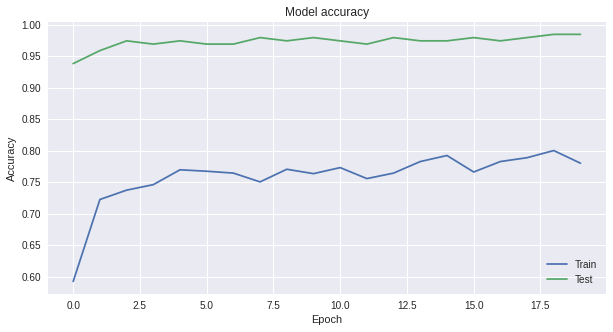

In [64]:
plt.rcParams['figure.figsize'] = [10, 5]

# Plot training & validation accuracy values
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('/drive/My Drive/FaceMask/accuracy.png')
plt.legend(['Train', 'Test'])

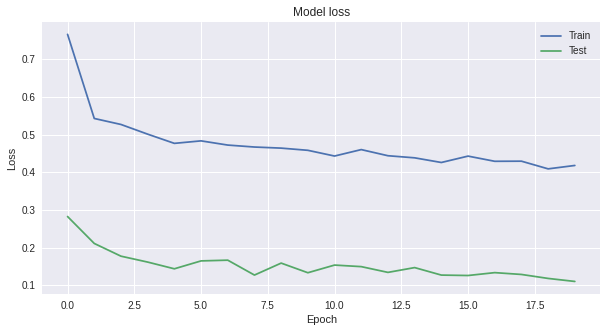

In [65]:
# Plot training & validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('/drive/My Drive/FaceMask/lost.png')
plt.legend(['Train', 'Test'])

## PREDICT

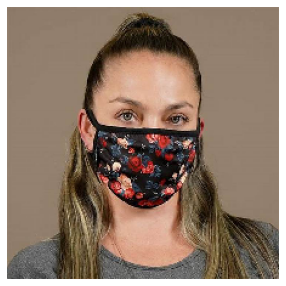

In [60]:
img = image.load_img('/drive/My Drive/FaceMask/data/adadads.jpg',target_size=(224,224))
plt.imshow(img)
plt.axis('off')
plt.show()

In [61]:
img = np.array(img, dtype='float')
img = img.reshape(1, 224, 224, 3)
prediksi = my_model.predict(img)
idx = np.argmax(prediksi)
print(idx)
if (idx):
    print("Wearing Masker")
else:
    print("Not Wearing Masker")

1
Wearing Masker
